In [2]:
import requests
import json
import pandas as pd
from collections import defaultdict
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def oauth_access_token():
    """
    Gets the access token for the Petfinder API.
    The API Key and secret are hardcoded.
    
    Returns:
        access_token (str): The private access token
    """
    
    # API key obtained from petfinder.com
    API_KEY = 'M4CoQE7WqFf5XuVwiW7cnq2IIBNxb7hXpl3YZuuloG1R6THzig'
    SECRET = '4GZGe1f9pPj2oH2DE7zGqSpeqyDIqFZ8oPaMtlpR'

    # Retrieves the access token using the API key and Secret
    access_token_req = requests.post('https://api.petfinder.com/v2/oauth2/token',
                data={
                    "grant_type": "client_credentials",
                    "client_id": API_KEY,
                    "client_secret": SECRET
                }).text

    # Processes the response from the Petfinder API
    return json.loads(access_token_req)['access_token']

In [4]:
# Obtains the access token
access_token = oauth_access_token()

In [7]:
def fetch_dogs(status='adopted', pages=50):
    """
    Fetches the specified number of pages of dog data.

    Args:
        status (String): can be either adopted or adoptable
        pages (Integer): specifies the number of pages to retrive from the site
    
    Returns:
        df (DataFrame): The raw API response concatenated into a DataFrame
    """
    all_dogs = []

    # Makes a series of requests sto the Petfind API to retrieve specified
    # information about dogs
    for page_num in range(1, 1+pages):
        response = requests.get('https://api.petfinder.com/v2/animals',
             headers={
                 'Authorization': f'Bearer {access_token}'
             },
             params={
                 'type': 'dog',
                 'after': '2022-01-01T00:00:00+00:00',
                 'before': '2023-01-01T00:00:00+00:00',
                 'page': str(page_num),
                 'status': status,
                 'limit': 100
             }).text

        # Processes the response from the Petfinder API
        for dog in json.loads(response)['animals']:
            all_dogs.append(dog)

    # Places obtained data into a Dataframe 
    return pd.DataFrame(all_dogs)

In [8]:
# Stores the data in a Dataframe
dogs_df = fetch_dogs()

In [9]:
def extract_features(df):
    """
    Pulls features from the columns which are 
    hidden in dicts, puts them back into the dataframe
    in their own columns 

    Args:
        df (Dataframe): the dataframe to be extracted from 
    
    Returns:
        df (DataFrame): the dataframe with new columns added for
        extracted features 
    """

    # Creates a new column within the dataframe which represents the amount of time taken
    # for a dog to be adopted 
    df['published_at'] = df['published_at'].apply(lambda x: datetime.fromisoformat(str(x)))
    df['status_changed_at'] = df['status_changed_at'].apply(lambda x: datetime.fromisoformat(str(x)))
    df['delta_time'] = df['status_changed_at'] - df['published_at']

    # Extracts primary_breed, secondary_breed, is_mixed, and is_unknown information
    # from the breeds column and creates a new column for each 
    df['primary_breed'] = df['breeds'].apply(lambda x: x['primary'])
    df['secondary_breed'] = df['breeds'].apply(lambda x: x['secondary'])
    df['is_mixed'] = df['breeds'].apply(lambda x: x['mixed'])
    df['is_unknown'] = df['breeds'].apply(lambda x: x['unknown'])

    # Extracts compatible_children, compatible_dogs, and compatible_cats information
    # from the environment column and creates a new column for each 
    df['compatible_children'] = df['environment'].apply(lambda x: x['children'])
    df['compatible_dogs'] = df['environment'].apply(lambda x: x['dogs'])
    df['compatible_cats'] = df['environment'].apply(lambda x: x['cats'])

    # Extracts spayed_neutered, house_trained, special_needs, and 
    # shots_current information from the attributes column and 
    # creates a new column for each 
    df['spayed_neutered'] = df['attributes'].apply(lambda x: x['spayed_neutered'])
    df['house_trained'] = df['attributes'].apply(lambda x: x['house_trained'])
    df['special_needs'] = df['attributes'].apply(lambda x: x['special_needs'])
    df['shots_current'] = df['attributes'].apply(lambda x: x['shots_current'])

    # Extracts primary_color, secondary_color, and tertiary_color information
    # from the colors column and creates a new column for each 
    df['primary_color'] = df['colors'].apply(lambda x: x['primary'])
    df['secondary_color'] = df['colors'].apply(lambda x: x['secondary'])
    df['tertiary_color'] = df['colors'].apply(lambda x: x['tertiary'])

In [10]:
# Extracts features embedded within dictionaries in dogs_df
extract_features(dogs_df)

In [11]:
# To observe the maximum amount of time taken to adopt a dog
dogs_df.delta_time.max()

Timedelta('336 days 00:46:22')

In [12]:
def clean_dogs(df):
    """
    Deletes invalid rows and unnecessary columns 
    from the DataFrame (after feature extraction!)

    Args:
        df (Dataframe): the dataframe to be cleaned
    
    Returns:
        df (DataFrame): the dataframe with unnecessary columns deleted
    """

    # Defines the columns deemed useless
    to_be_deleted = ['_links', 'type', 'species', 'breeds', 'colors', 
                'attributes', 'environment', 'videos', 'photos',
                'primary_photo_cropped', 'contact', 'distance',
                'description']

    # Removes the respective columns in to_be_deleted from df
    for col_name in to_be_deleted:
        del df[col_name]

In [13]:
# Removes useless columns from dogs_df
clean_dogs(dogs_df)

In [14]:
# Remove invalid entries
dogs_df = dogs_df.loc[dogs_df['delta_time'] > timedelta(minutes=5)]

In [15]:
# To determine the number of dogs with special needs
dogs_df[dogs_df['special_needs'] == True].shape

(124, 28)

In [16]:
# To determine the number of dogs without special needs
dogs_df[dogs_df['special_needs'] == False].shape

(4813, 28)

In [17]:
# Create delta_time_minutes column - converts delta_time to minutes instead
dogs_df['delta_time_minutes'] = dogs_df['delta_time'].apply(lambda x: x.seconds / 60)
dogs_df['delta_time_minutes']

0       1213.833333
1       1015.283333
2        733.033333
3       1255.850000
4       1359.433333
           ...     
4995     917.000000
4996      57.050000
4997    1288.566667
4998    1272.966667
4999      51.733333
Name: delta_time_minutes, Length: 4937, dtype: float64

In [18]:
# stores the dogs_df as a csv
dogs_df.to_csv('dogs.csv')

# Visualizations

In [19]:
# Reads in the csv file 
dogs_df = pd.read_csv('dogs.csv')
dogs_df.drop(columns='Unnamed: 0', inplace=True)
dogs_df.head()

,id,organization_id,url,age,gender,size,coat,tags,name,organization_animal_id,...,compatible_dogs,compatible_cats,spayed_neutered,house_trained,special_needs,shots_current,primary_color,secondary_color,tertiary_color,delta_time_minutes
0,59313263,CA2713,https://www.petfinder.com/dog/billy-59313263/c...,Adult,Male,Small,Short,"['Friendly', 'Affectionate', 'Funny', 'Couch p...",BILLY,NaN,...,True,True,True,True,False,True,Yellow / Tan / Blond / Fawn,NaN,NaN,1213.833333
1,59313260,IL54,https://www.petfinder.com/dog/ula-59313260/il/...,Adult,Female,Medium,Short,[],Ula,NaN,...,NaN,NaN,True,False,False,True,NaN,NaN,NaN,1015.283333
2,59313253,FL532,https://www.petfinder.com/dog/jake-59313253/fl...,Young,Male,Medium,Medium,"['Brave', 'Athletic', 'Funny', 'Smart', 'Loyal']",Jake,NaN,...,True,True,True,True,False,True,Merle (Blue),NaN,NaN,733.033333
3,59313248,CA2813,https://www.petfinder.com/dog/marshmallow-5931...,Young,Male,Large,Short,[],Marshmallow,NaN,...,True,NaN,True,True,True,True,White / Cream,NaN,NaN,1255.850000
4,59313245,TX258,https://www.petfinder.com/dog/riley-loves-ever...,Young,Female,Large,Short,"['Smart', 'Playful', 'Gentle', 'Loyal', 'Affec...",Riley- Loves Everyone and Learns Quickly!,NaN,...,True,NaN,True,True,False,True,Brindle,NaN,NaN,1359.433333


In [21]:
# Creates correlation matrix 
dogs_df.corr(numeric_only = True)

,id,is_mixed,is_unknown,spayed_neutered,house_trained,special_needs,shots_current,delta_time_minutes
id,1.000000,0.020534,NaN,-0.013682,-0.020196,0.001724,-0.006653,0.006674
is_mixed,0.020534,1.000000,NaN,-0.001223,-0.040803,-0.029608,0.073126,0.002460
is_unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
spayed_neutered,-0.013682,-0.001223,NaN,1.000000,0.280460,0.054575,0.326724,-0.004543
house_trained,-0.020196,-0.040803,NaN,0.280460,1.000000,0.058828,0.128702,0.007053
special_needs,0.001724,-0.029608,NaN,0.054575,0.058828,1.000000,-0.003416,0.022315
shots_current,-0.006653,0.073126,NaN,0.326724,0.128702,-0.003416,1.000000,-0.057502
delta_time_minutes,0.006674,0.002460,NaN,-0.004543,0.007053,0.022315,-0.057502,1.000000


/Users/madisonweiss/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/madisonweiss/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/madisonweiss/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/madisonweiss/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

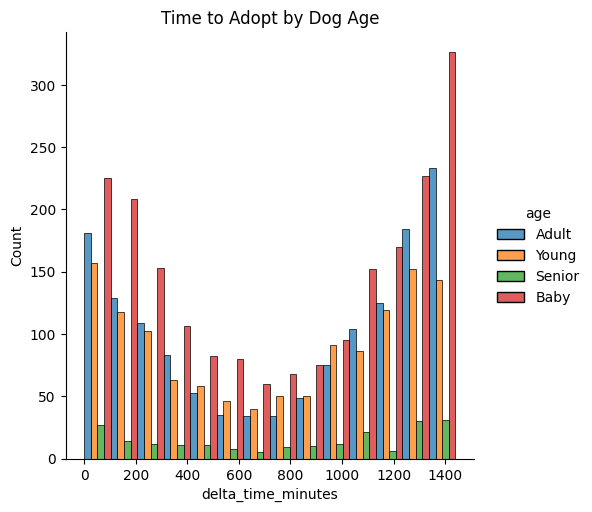

In [24]:
# Visualizes age versus the time taken to adopt 
fig = sns.displot(dogs_df, x='delta_time_minutes', hue='age', multiple='dodge')
fig.set(title='Time to Adopt by Dog Age')

In the above graph, Time to Adopt by Dog Age, we created a histogram, displaying how time to adoption is distributed into different buckets based on the age of the dogs. Buckets of time to adoption are on the x axis, with counts of dogs falling into that bucket on the y axis, split into different color bars by age. 

In [25]:
# Used to observed the unique colors of dogs 
dogs_df.primary_color.unique()

array(['Yellow / Tan / Blond / Fawn', nan, 'Merle (Blue)',
       'White / Cream', 'Brindle', 'Black', 'Bicolor',
       'Tricolor (Brown, Black, & White)', 'Apricot / Beige',
       'Gray / Blue / Silver', 'Red / Chestnut / Orange', 'Golden',
       'Brown / Chocolate', 'Merle (Red)', 'Harlequin', 'Sable'],
      dtype=object)

/Users/madisonweiss/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/madisonweiss/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/madisonweiss/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


[Text(0.5, 1.0, 'Time to Adoption by Dog Color')]

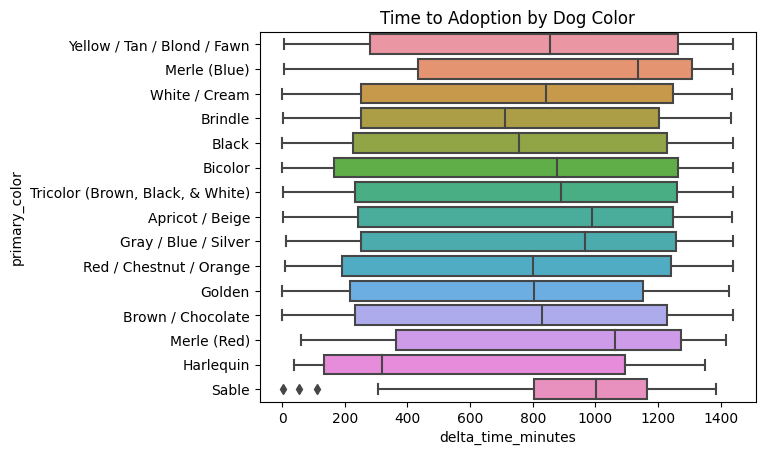

In [27]:
# Visualizes primary_color versus the time taken to adopt 
fig = sns.boxplot(dogs_df, x='delta_time_minutes', y='primary_color')
fig.set(title='Time to Adoption by Dog Color')

This graph shows the distribution of time to adoption in minutes based on a dog’s coat color. To show this, we used several box and whisker plots. All of the distributions have similar spreads, although each has varying medians.

Text(0.5, 1.0, 'Compatible with dogs')

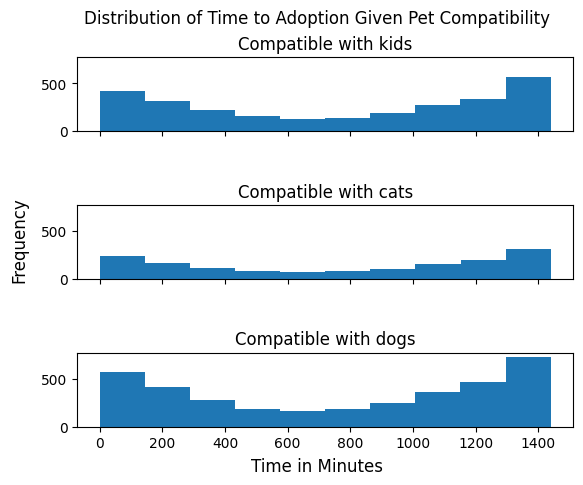

In [28]:
# Creates Dataframes in which the following 3 specified columns
# only contain values which are true 
dogs_w_kids = dogs_df[dogs_df['compatible_children'] == True]
dogs_w_cats = dogs_df[dogs_df['compatible_cats'] == True]
dogs_w_dogs = dogs_df[dogs_df['compatible_dogs'] == True]

# For formatting purposes
fig = plt.figure()
gs = fig.add_gridspec(nrows=3, ncols=1, hspace=1)
axs = gs.subplots(sharex=True, sharey=True)

# Labels the plot 
fig.suptitle('Distribution of Time to Adoption Given Pet Compatibility')
fig.supxlabel('Time in Minutes')
fig.supylabel('Frequency')

# Initializes the first subplot to compare compatibility 
# with children to time to adoption
axs[0].hist(dogs_w_kids['delta_time_minutes'])
axs[0].set_title('Compatible with kids')

# Initializes the second subplot to compare compatibility 
# with cats to time to adoption
axs[1].hist(dogs_w_cats['delta_time_minutes'])
axs[1].set_title('Compatible with cats')

# Initializes the third subplot to compare compatibility 
# with dogs to time to adoption
axs[2].hist(dogs_w_dogs['delta_time_minutes'])
axs[2].set_title('Compatible with dogs')

This visualization plots the distribution of time to adoption given pet compatibility including compatibility with children, compatibility with other dogs, and compatibility with cats. We plotted each within a subplot. Buckets of time to adoption are on the x axis, with counts of dogs falling into that bucket on the y axis. 

In [29]:
# Drops null values for compatibility columns
dogs_df.dropna(subset=['compatible_dogs', 'compatible_cats', 'compatible_children'], inplace=True)
dogs_df.reset_index(inplace=True)
dogs_df.head()

,index,id,organization_id,url,age,gender,size,coat,tags,name,...,compatible_dogs,compatible_cats,spayed_neutered,house_trained,special_needs,shots_current,primary_color,secondary_color,tertiary_color,delta_time_minutes
0,0,59313263,CA2713,https://www.petfinder.com/dog/billy-59313263/c...,Adult,Male,Small,Short,"['Friendly', 'Affectionate', 'Funny', 'Couch p...",BILLY,...,True,True,True,True,False,True,Yellow / Tan / Blond / Fawn,NaN,NaN,1213.833333
1,2,59313253,FL532,https://www.petfinder.com/dog/jake-59313253/fl...,Young,Male,Medium,Medium,"['Brave', 'Athletic', 'Funny', 'Smart', 'Loyal']",Jake,...,True,True,True,True,False,True,Merle (Blue),NaN,NaN,733.033333
2,8,59313185,AL444,https://www.petfinder.com/dog/springs-59313185...,Young,Female,Large,Short,"['Friendly', 'Affectionate', 'Quiet']",Springs,...,True,True,True,True,False,True,Bicolor,NaN,NaN,1269.450000
3,10,59263354,TX2594,https://www.petfinder.com/dog/ariel-59263354/t...,Baby,Female,Medium,Short,"['Friendly', 'Affectionate', 'Gentle', 'Playfu...",Ariel,...,True,True,False,False,False,True,Black,NaN,NaN,1127.616667
4,11,59313109,SC178,https://www.petfinder.com/dog/rocky-59313109/s...,Young,Male,Medium,Short,"['Friendly', 'Gentle', 'Loyal', 'Playful', 'Af...",Rocky,...,True,True,False,True,False,False,"Tricolor (Brown, Black, & White)",NaN,NaN,119.766667
